### Text classifier (a simple sentiment classifier ) using Large Movie Review Dataset

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from util import load_directory_data,load_dataset,download_and_load_datasets
print ("Packages loaded.")

Packages loaded.


### Get dataset

In [2]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,Never before have the motives of the producers...,1,0
1,i saw switching goals ..twice....and always th...,3,0
2,"""FULL HOUSE,"" in my opinion, is an absolute AB...",9,1
3,"I thought ""Intensive Care"" was quite bad and v...",3,0
4,I have rarely been subjected to such outright ...,1,0


In [3]:
train_df['sentence']

0        Never before have the motives of the producers...
1        i saw switching goals ..twice....and always th...
2        "FULL HOUSE," in my opinion, is an absolute AB...
3        I thought "Intensive Care" was quite bad and v...
4        I have rarely been subjected to such outright ...
5        After Disney's witty live-action George of the...
6        Not a bad film. Somehow I was made to actually...
7        I sought out a copy of The Forest because I wa...
8        Fans of the HBO series "Tales From the Crypt" ...
9        The film is poorly casted, except for some fam...
10       Of all the reviews I've read, most people have...
11       Perhaps I would have liked this film more if I...
12       T.Z. Post, college professor, receives a false...
13       Jake's Closet has the emotional power of Krame...
14       CAT SOUP is a short anime based on the legenda...
15       This is a film exploring the female sexuality ...
16       A surprisingly effective thriller, this.<br />.

In [4]:
train_df['polarity']

0        0
1        0
2        1
3        0
4        0
5        0
6        1
7        0
8        1
9        0
10       1
11       1
12       0
13       1
14       1
15       1
16       1
17       0
18       0
19       1
20       0
21       0
22       1
23       0
24       1
25       0
26       1
27       1
28       1
29       1
        ..
24970    1
24971    1
24972    1
24973    0
24974    0
24975    1
24976    1
24977    1
24978    1
24979    1
24980    0
24981    0
24982    0
24983    0
24984    0
24985    0
24986    1
24987    1
24988    1
24989    1
24990    1
24991    1
24992    0
24993    0
24994    1
24995    0
24996    0
24997    0
24998    0
24999    0
Name: polarity, Length: 25000, dtype: int64

### Model

In [5]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)
# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

### Get feature

In [6]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

### Estimator

In [7]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

### Training

In [8]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000)
print ("Done.")

Done.


### Prediction

In [9]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8000800013542175
Test set accuracy: 0.7925999760627747


###  Confusion matrix

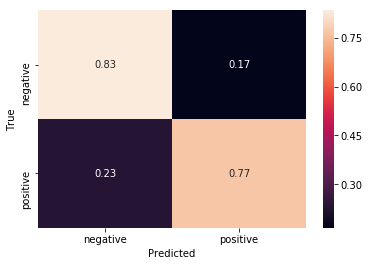

In [10]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");